In [1]:
%matplotlib inline

In [ ]:
'''
Generates XDGMM-based models from a selection of formatted CSV files of galaxies or quasars.
Plots the models, the original data, and resampled data based on the model.
'''

In [1]:
'''
method name: fetchValsByEpoch
purpose: takes information from csv files of galaxy/quasar objects and reads it into a set of arrays
args:
- epoch:epoch number (i.e. column in csv)
- directorystr: string name of directory (e.g. "/csvfiles/galaxies")
returns:
- deltaW: array of W1-W2 data
- sigW: array of the uncertainty on each deltaW value
- notNullCount: number of files that did not have a null in that epoch
- name: list of the names of all the objects
- mjd: list of the MJD dates of each object's epoch
'''

import sklearn
import nose
import astroML_addons
import astroML
import scipy
import pandas
import xdgmm
from astropy.io import fits
import csv
import os
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
import requests
import ast

import warnings
warnings.filterwarnings('ignore')

def fetchValsByEpoch(epoch, directorystr):
    
    deltaW = []
    sigW = []
    w1 = []
    w2 = []
    w1s = []
    w2s = []
    mjd = []
    name = []
    
    directory = os.fsencode(directorystr)
    filelist = os.listdir(directory)
    print(len(filelist))
    readdata = np.zeros((22,len(filelist)+1)) #one big list to rule them all
    fileCount = 0 #to keep our place in each list as we go through the files
    blankCount = 0
    for file in filelist:
        filestr = os.fsdecode(file)
        if(filestr.endswith(".csv")):
            readfile = open(directorystr+filestr, 'r')
            #name.append(filestr)
            reader = csv.reader(readfile)
            typeIndex = 0 #to iterate through the w1, w2, etc list
            nullCount = 0
            rowCount = 0
            
            for row in enumerate(reader):
                if rowCount < 5 or rowCount >= 14:
                    if rowCount == 0 and row[1][1] == "null|":
                        #print("Empty csv")
                        nullCount = nullCount + 1 #skip this file
                    rowCount = rowCount + 1
                    continue #skip the first and last rows
                try:
                    entry = row[1][epoch]
                except IndexError:
                    rowCount = rowCount + 1
                    continue
                try:
                    fentry = float(entry)
                    readdata[typeIndex][fileCount] = fentry
                except ValueError:
                    if entry != 'null': #this is a label; skip it
                        rowCount = rowCount + 1 #keep track of where we are in the file
                        continue #skip to next row, do not increment readdata row
                    else: #this file isn't useful
                        readdata[typeIndex][fileCount] = 99
                        nullCount = nullCount + 1 #this is a null in W1 or W2. don't want this file
                rowCount = rowCount + 1 #move on to the next row in the file
                typeIndex = typeIndex + 1 #move to next row in the data array
            if nullCount == 0:
                fileCount = fileCount + 1 #overwrite if we found null in W1, W2.
                name.append(filestr)
                
    print("Error count: " + str(blankCount))    
    w1 = [round(float(x), 4) for x in readdata[1]]
    w2 = [round(float(x), 4) for x in readdata[3]]
    w1s = [round(float(x), 4) for x in readdata[2]]
    w2s = [round(float(x), 4) for x in readdata[4]]
    mjd = [float(x) for x in readdata[0]]
    
    deltaW = [x - y for x,y in zip(w1,w2)]
    sigW = [np.sqrt(sx**2 + sy**2) for sx,sy in zip(w1s, w2s)]
    
    notNullCount = 0
    for val in w1:
        if val != 0:
            notNullCount = notNullCount + 1
    deltaW = deltaW[:notNullCount]
    sigW = sigW[:notNullCount] #trim the array of the extra length

    return deltaW, sigW, notNullCount, name, mjd

In [2]:
'''
Constructs data arrays (deltaW, sigW, radec etc) in the correct formatting for the XDGMM algorithm
'''

print("starting")
result = fetchValsByEpoch(0, "./csvfiles/galaxies/") # or, your directorystr here
deltaW = result[0]
sigW = result[1]
npoints = result[2]

param_range = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
deltaW = np.array(deltaW)

deltaW = deltaW.reshape(deltaW.shape[0], 1)
sigW = np.array(sigW)

sigW = sigW.reshape(sigW.shape[0], 1,1)

print("done")



starting
71581
Error count: 0
done


In [4]:
'''
Instantiates the XDGMM object (named xdgmm)
Performs BIC test (to determine optimum number of Gaussians to fit)
Note that this may take many hours to complete, if the sample size is large.
'''

print("starting")

xdgmm = xdgmm.XDGMM()

bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(deltaW, sigW, param_range)

print('done')

starting
N = 1 , BIC = 37794.2880012
N = 2 , BIC = 38233.984868
N = 3 , BIC = 38838.3833408
N = 4 , BIC = 39046.1591535
N = 5 , BIC = 39234.1206955
N = 6 , BIC = 39196.3022565
N = 7 , BIC = 37930.5239407
N = 8 , BIC = 37978.8387158
N = 9 , BIC = 37735.3741966
N = 10 , BIC = 38416.522563
done


In [16]:
'''
Adds model to xdgmm
Saves model to file
'''

import datetime
datestr = datetime.datetime.now().strftime("%Y-%m-%d")

print("starting")
xdgmm.n_components = optimal_n_comp
xdgmm = xdgmm.fit(deltaW, sigW)
print('done')

xdgmm.save_model('galaxyModel'+datestr+'.fit')

starting
done


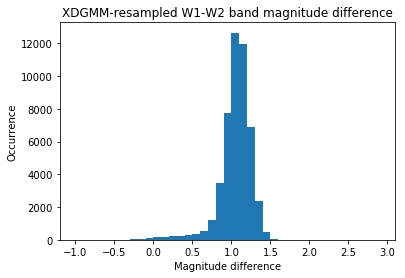

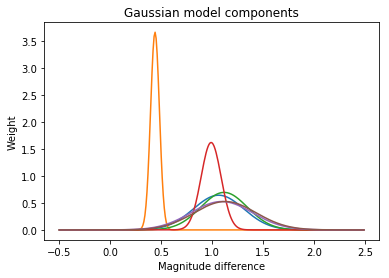

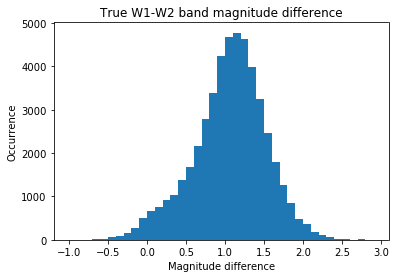

In [18]:
'''
Plots the models. Insert your own model save files.
'''

%matplotlib inline


import sklearn
import nose
import astroML_addons
import astroML
import scipy
import pandas
import xdgmm
from astropy.io import fits
import csv
import os
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt

import requests
import ast

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(threshold=np.nan)

xdgmm = xdgmm.XDGMM(filename='galaxyModel2018-03-28.fit')         
    
def makeGaussian(x, mu, sig):
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))/(2.0*np.pi*sig)

binwidth = 0.1

sample = xdgmm.sample(npoints)
plt.figure()
h1 = plt.hist(sample, bins=np.arange(-1, 3, binwidth))
plt.title('XDGMM-resampled W1-W2 band magnitude difference')
plt.xlabel('Magnitude difference')
plt.ylabel('Occurrence')

plt.figure()

x = np.arange(-0.5, 2.5, 0.01)
plt.plot(x, makeGaussian(x, xdgmm.mu[0], xdgmm.weights[0]))
plt.plot(x, makeGaussian(x, xdgmm.mu[1], xdgmm.weights[1]))
plt.plot(x, makeGaussian(x, xdgmm.mu[2], xdgmm.weights[2]))
plt.plot(x, makeGaussian(x, xdgmm.mu[3], xdgmm.weights[3]))
plt.plot(x, makeGaussian(x, xdgmm.mu[4], xdgmm.weights[4]))
plt.plot(x, makeGaussian(x, xdgmm.mu[5], xdgmm.weights[4]))
# plt.plot(x, makeGaussian(x, xdgmm.mu[6], xdgmm.weights[4]))
# plt.plot(x, makeGaussian(x, xdgmm.mu[7], xdgmm.weights[4]))
# plt.plot(x, makeGaussian(x, xdgmm.mu[8], xdgmm.weights[4]))
plt.title('Gaussian model components')
plt.xlabel('Magnitude difference')
plt.ylabel('Weight')


plt.figure()

plt.hist(deltaW, bins=np.arange(-1, 3, binwidth))
plt.title('True W1-W2 band magnitude difference')
plt.xlabel('Magnitude difference')
plt.ylabel('Occurrence')
